In [1]:
from neo4j import GraphDatabase, basic_auth
import pandas as pd

In [2]:
# launch neoj4 browser and start an instance of the database
driver = GraphDatabase.driver(
  "bolt://localhost:7687",
  auth=basic_auth("neo4j", "alex"))


### Github example Query

In [3]:
cypher_query = '''
MATCH (a:Officer {name:$name})-[r:officer_of|intermediary_of|registered_address*..10]-(b)
RETURN b.name as name LIMIT 20
'''

In [4]:
with driver.session(database="neo4j") as session:
    results = session.read_transaction(
        lambda tx: tx.run(cypher_query,
                      name="Ross, Jr. - Wilbur Louis").data())
    print(len(results))
    for record in results:
        print(record['name'])

driver.close()

20
WL Ross & Co. LLC; 1166 Avenue of the Americas; 25th Floor; New York New York  11036; United States of America
WLR Recovery Fund IV L.P.
WLR IV CLPG L.P.
Walkers Corporate Services Limited, Walker House, 87 Mary Street, George Town; KY1-9005, Grand Cayman; Cayman Islands
Taiyo Greater India Fund GP Ltd.
Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands
Dynap Management Ltd
DYNap Fund SPC
Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands
Seville Holdings Ltd.
Coller International Partners IV-FD, L.P.
OGP IV (Caymans), Ltd.
AEI
Ghada A. Alireza Company, Ltd.
Offshore, Design & Contracting Ltd. ** INCOMPLETE **
ADAMAS INVESTMENTS LTD.
GRANITE HOLDINGS LTD.
Coller International General Partner IV, L.P.
Coller International Partners IV-E, L.P.
WEST BAY BEACH HOLDINGS


### New examples

In [5]:
cypher_query2 = '''
MATCH p=()-[r:officer_of]->() RETURN p LIMIT 25
'''

In [26]:
with driver.session(database="neo4j") as session:
    results = session.run(cypher_query2)

    final = []
    #print(results)
    for record in results:
        # gets the value of the record
        final.append(record.values()[0])
        #print(record.values())
        
        

driver.close()

In [75]:
y = final[0]
# gets the first node and it is a Path object
type(y)

neo4j.graph.Path

In [76]:
# has two nodes
y.nodes

(<Node id=228598 labels=frozenset({'Officer'}) properties={'sourceID': 'Panama Papers', 'lastEditTimestamp': '1638311034062', 'valid_until': 'The Panama Papers data is current through 2015', 'name': 'KIM SOO IN', 'icij_id': 'E72326DEA50F1A9C2876E112AAEB42BC', 'country_codes': 'KOR', 'countries': 'South Korea', 'node_id': 12000001}>,
 <Node id=74508 labels=frozenset({'Entity'}) properties={'sourceID': 'Panama Papers', 'address': 'MR WALTER KIM; ESQ. \t CO RODI & POLLOCK  444 SOUTH FLOWER STREET; SUITE 1700  LOS ANGELES; CA 90071  U.S.A.', 'internal_id': '520074', 'jurisdiction': 'BVI', 'struck_off_date': '31-OCT-2007', 'service_provider': 'Mossack Fonseca', 'countries': 'United States', 'jurisdiction_description': 'British Virgin Islands', 'lastEditTimestamp': '1638311021758', 'valid_until': 'The Panama Papers data is current through 2015', 'ibcRUC': '211317', 'original_name': 'TOPSON MARK LIMITED', 'name': 'TOPSON MARK LIMITED', 'country_codes': 'USA', 'inactivation_date': '01-NOV-2007

In [77]:
i = 0
for n in y.nodes:
    # gets each item in the node 
    i += 1
    print("Node #{0}".format(i))
    # node type
    print(tuple(n.labels)[0])
    print(n["name"])
    print(n["country_codes"])
    print("---------------------")
    

Node #1
Officer
KIM SOO IN
KOR
---------------------
Node #2
Entity
TOPSON MARK LIMITED
USA
---------------------


In [47]:
tuple(y.nodes[0].labels)[0] # grabs the node type

'Officer'

### Script to convert query to CSV format

In [5]:
script_query = "MATCH (o:Officer) WHERE size( (o)--() ) > 100 MATCH (o)-[connection]-(e:Entity) RETURN o.name as Officer, type(connection) as relationship, head(labels(e)) as type, count(*) as count ORDER BY count DESC LIMIT 20"

In [6]:
def neotocsv(filename, query):
    with driver.session(database="neo4j") as session:
        results = session.run(query)

        # allows to put header for csv
        i = 0
        #final = []
        file = "data/"+filename
        with open(file, "w+") as f:

            for record in results:

                # write header keys
                if i == 0:
                    i += 1
                    head = ""

                    for k in record.keys():
                        k = str(k).replace(",","")
                        head += k + ","
                    
                    lastCommaIndex = head.rfind(",")
                    newHead = head[:lastCommaIndex] + "\n"
                    f.write(newHead)

                # addes data to CSV
                data = ""
                for v in record.values():
                    v = str(v).replace(",","")
                    data += str(v) + ","

                lastCommaIndex = data.rfind(",")
                newData = data[:lastCommaIndex] + "\n"
                f.write(newData)
                
                #final.append(record.values()[0])
                
                
            

    driver.close()

In [8]:
from qtocsv import neotocsv

In [7]:
neotocsv("test2.csv",script_query,driver)

# QUERY FOR BEAR SHARES
CALL gds.pageRank.stream({nodeProjection:'*',relationshipProjection:'*'}) YIELD nodeId, score WITH gds.util.asNode(nodeId) as node, score WHERE node:Officer AND node.sourceID STARTS WITH "Panama Papers" WITH * ORDER BY score DESC LIMIT 10 MATCH ()<-[r:officer_of]-(o:Officer) RETURN o.name, count(o) AS count, r.link as relationship ORDER BY count DESC

In [4]:
bear = pd.read_csv("data/num_bear.csv")
bear.head()

,entity,num_bearer
0,VELA GAS INVESTMENTS LTD.,492.0
1,GNG LTD.,200.0
2,BOB AGENTS LIMITED,165.0
3,3 DIP S.A.,110.0
4,INGELSA LTD.,107.0


In [5]:
country = pd.read_csv("data/country.csv")
country.head()

,e.name,e.countries
0,TIANSHENG INDUSTRY AND TRADING CO. LTD.,Hong Kong
1,NINGBO SUNRISE ENTERPRISES UNITED CO. LTD.,Hong Kong
2,HOTFOCUS CO. LTD.,Hong Kong
3,SKY-BLUE GIFTS & TOYS CO. LTD.,Hong Kong
4,FORTUNEMAKER INVESTMENTS CORPORATION,Hong Kong


Query for all entities and Count:::

MATCH p =(e:Entity)
WHERE e.sourceID = "Panama Papers"
RETURN e.countries, count(e) ORDER BY COUNT(e) DESC

In [6]:
country_count_query = "MATCH p =(e:Entity) WHERE e.sourceID = 'Panama Papers' RETURN e.countries, count(e) ORDER BY COUNT(e) DESC"

In [11]:
neotocsv("country_count.csv",country_count_query,driver)

In [20]:
country_count = pd.read_csv("data/country_count.csv")
country_count = country_count.rename(columns={"e.countries":"Country", "count(e)":"Count"})
country_count.head()

,Country,Count
0,Hong Kong,37911
1,Switzerland,37911
2,Panama,15811
3,Jersey,14331
4,Luxembourg,10840


In [21]:
import matplotlib.pyplot as plt

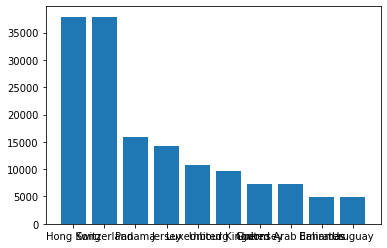

In [22]:
plt.bar(country_count.head(10)["Country"], country_count.head(10)["Count"])
plt.show()

### Counting Number of Bear Shares per entity

In [6]:
bearQuery = "MATCH p=(o:Officer)-[]->()<-[s:intermediary_of]-(i:Intermediary) WHERE toLower(o.name) = \"the bearer\" return p LIMIT 3"

In [9]:
with driver.session(database="neo4j") as session:
    results = session.run(bearQuery)

    final = []
    #print(results)
    for record in results:
        # gets the value of the record
        #final.append(record.values()[0])
        print(record)
        print(record.keys())
        print(record.values())
        final.append(record.values())
        break
        

driver.close()

<Record p=<Path start=<Node id=229028 labels=frozenset({'Officer'}) properties={'sourceID': 'Panama Papers', 'lastEditTimestamp': '1638311034062', 'valid_until': 'The Panama Papers data is current through 2015', 'name': 'THE BEARER', 'icij_id': '1BA193B71D623B8FA1B3127011BF3E01', 'node_id': 12002946}> end=<Node id=214488 labels=frozenset({'Intermediary'}) properties={'sourceID': 'Panama Papers', 'lastEditTimestamp': '1638311034131', 'address': 'MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET BROOKLYN PRETORIA 0002; GAUTENG (PWV) SOUTH AFRICA', 'valid_until': 'The Panama Papers  data is current through 2015', 'internal_id': '10001', 'name': 'MICHAEL PAPAGEORGE, MR.', 'country_codes': 'ZAF', 'countries': 'South Africa', 'status': 'ACTIVE', 'node_id': 11000001}> size=2>>
['p']
[<Path start=<Node id=229028 labels=frozenset({'Officer'}) properties={'sourceID': 'Panama Papers', 'lastEditTimestamp': '1638311034062', 'valid_until': 'The Panama Papers data is current through 2015', 'name': 'THE BE

In [15]:
path = final[0][0]
path

<Path start=<Node id=229028 labels=frozenset({'Officer'}) properties={'sourceID': 'Panama Papers', 'lastEditTimestamp': '1638311034062', 'valid_until': 'The Panama Papers data is current through 2015', 'name': 'THE BEARER', 'icij_id': '1BA193B71D623B8FA1B3127011BF3E01', 'node_id': 12002946}> end=<Node id=214488 labels=frozenset({'Intermediary'}) properties={'sourceID': 'Panama Papers', 'lastEditTimestamp': '1638311034131', 'address': 'MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET BROOKLYN PRETORIA 0002; GAUTENG (PWV) SOUTH AFRICA', 'valid_until': 'The Panama Papers  data is current through 2015', 'internal_id': '10001', 'name': 'MICHAEL PAPAGEORGE, MR.', 'country_codes': 'ZAF', 'countries': 'South Africa', 'status': 'ACTIVE', 'node_id': 11000001}> size=2>